# Activity: Data Reduction using Principal Component Analysis (PCA)
In this activity, we'll use the eigendecomposition of the empirical covariance matrix to perform Principal Component Analysis (PCA) on a dataset. PCA is a widely used statistical technique for reducing the dimensionality of data while preserving as much variance as possible.

> __Learning Objectives:__
> 
> By the end of this activity, you should be able to:
> 
> * __Compute empirical covariance matrices from clinical data:__ Calculate sample covariance matrices from preprocessed datasets and verify results against standard implementations using matrix operations.
> * __Apply QR iteration for eigendecomposition:__ Use the QR algorithm to compute eigenvalues and eigenvectors of covariance matrices and validate results through eigenvalue equation verification.
> * __Perform dimensionality reduction with PCA:__ Project high-dimensional data onto principal component subspaces and interpret variance patterns in reduced representations.


Let's get started!

___

## Dimensionality Reduction Problem
Suppose we have a dataset $\mathcal{D} = \left\{\mathbf{x}_{1},\mathbf{x}_{2},\dots,\mathbf{x}_{n}\right\}$ where $\mathbf{x}_{i}\in\mathbb{R}^{m}$ is an $m$-dimensional feature vector that we want to compress into $k$ dimensions: $\mathbf{x}_i \in \mathbb{R}^m \;\rightarrow\; \mathbf{y}_i \in \mathbb{R}^k$ where $k\ll{m}$. Reducing dimensionality can help us visualize high-dimensional data in 2–3D, reduce the computational complexity of a machine learning algorithm, or give us a more compact representation of the data that retains the most important information.

> **Composite features.**  Each lower-dimensional vector $\mathbf{y}_i$ is called a *composite feature*, since it's a linear combination of the original features. But how do we choose the linear combinations that define the composite features? That's where the covariance matrix and eigendecomposition comes into play.

Imagine that we have a _magical transformation matrix_ $\mathbf{P}\in\mathbb{R}^{k\times{m}}$ so that: $\mathbf{y} = \mathbf{P}\;(\mathbf{x} - \bar{\mathbf{x}})$ where $\mathbf{y}\in\mathbb{R}^{k}$ is the new composite feature vector, $\mathbf{x}\in\mathbb{R}^m$ is the original feature vector, and $\bar{\mathbf{x}}$ is the mean of the features in the (original) data.  

> **Why center the data?** We subtract the mean $\bar{\mathbf{x}}$ because dimensionality reduction seeks directions of maximum _variance_ in the data. If we don't center, we'd be measuring distance from the origin rather than spread around the data's natural center. Centering ensures that our reduced representation captures the actual variation patterns in the data, not just where the data happens to sit in space.

If we write $\mathbf{P} = [\,\mathbf{\phi}_1^\top;\dots;\mathbf{\phi}_k^\top]$, then each row $\mathbf{\phi}_i^\top$ extracts one component of the new composite feature vector $\mathbf{y}$:
$$
\begin{align*}
y_{i} = \mathbf{\phi}_{i}^{\top}\;(\mathbf{x} - \bar{\mathbf{x}})\quad{i=1,2,\dots,k}\quad\forall{\mathbf{x}\in\mathcal{D}}
\end{align*}
$$

Wow, that sounds great!  What are these magical transformation vectors $\mathbf{\phi}_{i}^{\top}$? 

__TL;DR.__ The $\mathbf{\phi}_{i}^{\top}$ vectors are the top-$k$ eigenvectors (those corresponding to the $k$ largest eigenvalues) of the data's covariance matrix, and this reduction procedure has a special name, it is known as __Principal Component Analysis (PCA)__.

___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:


__Instructions:__ Uncomment the code below to include `Include.jl` and set up the environment.


In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:


__Instructions:__ Uncomment the code below to load the heart disease dataset into `originaldataset`.


In [3]:
originaldataset = MyHeartDiseaseClinicalDataset() # load the heart disease dataset

Row,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64
1,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,55.0,0,7861,0,38,0,263358.0,1.1,136,1,0,6,1
3,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
4,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
6,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
7,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
8,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
9,65.0,0,157,0,65,0,263358.0,1.5,138,0,0,10,1


#### Data scaling
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) requires [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}), not [a `DataFrame`](https://dataframes.juliadata.org/stable/). We preprocess the data in three steps:

> __Data Preprocessing:__
> 
> * __Binary recoding:__ Convert categorical `0,1` data to `-1,1` where `0` maps to `-1` and `1` remains `1`.
> * __Z-score normalization:__ Apply [z-score scaling](https://en.wikipedia.org/wiki/Feature_scaling) to continuous features using $x^{\prime} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation.
> * __Label exclusion:__ Remove the `death_event` label to test whether feature similarity corresponds to clinical outcomes.

The preprocessed data is stored in `X::Matrix{Float64}`, while the treated dataset is in `dataset::DataFrame`.


__Instructions:__ Uncomment the code below to preprocess the dataset, z-scale the selected features, and build `X` and `dataset`. Then, uncomment the next cell to inspect `X`.


In [4]:
(X, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # remove categorical cols -
    # D̂₂ = D̂[:,index_to_z_scale]; # z-scaled data, no label, no categorical
    D̂₂ = D̂[:,1:end-1]; # z-scaled data, no label, with unscaled categorical
    # D̂₂ = D[:,1:end-1]; # raw (unscaled) data, no label
    
    D̂₂, treated_dataset
end;


In [5]:
X

299×12 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …  -1.50152     1.0  -1.0  -1.62678
 -0.490457   -1.0   7.50206      -1.0     -0.141739    1.0  -1.0  -1.60101
  0.350246   -1.0  -0.449186     -1.0     -1.72815     1.0   1.0  -1.58812
 -0.910808    1.0  -0.485257     -1.0      0.0848915   1.0  -1.0  -1.58812
  0.350246    1.0  -0.434757      1.0     -4.67434    -1.0  -1.0  -1.57524
  2.452       1.0  -0.551217     -1.0  …  -1.04826     1.0   1.0  -1.57524
  1.19095     1.0  -0.346124     -1.0      0.0848915   1.0  -1.0  -1.54947
 -0.0701056   1.0  -0.275011      1.0     -1.27489     1.0   1.0  -1.54947
  0.350246   -1.0  -0.437849     -1.0      0.311522   -1.0  -1.0  -1.54947
  1.6113      1.0  -0.47289      -1.0     -0.821629    1.0   1.0  -1.54947
  ⋮                                    ⋱                     ⋮    
 -1.33116    -1.0   0.034176      1.0  …   0.991412   -1.0  -1.0   1.63294
 -0.0701056  -1.0  -0.269858     -1.0      0.538152    1.0  -1.0   1.64582
 -0.74266

___

## Task 1: Compute the Empirical Covariance Matrix
In this task, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ using the preprocessed data matrix `X`. The empirical covariance matrix is given by:
$$
\hat{\mathbf{\Sigma}} = \frac{1}{n-1}\tilde{\mathbf{X}}^{\top}\tilde{\mathbf{X}}
$$
where $\tilde{\mathbf{X}}$ is the centered data matrix:
$$
\tilde{\mathbf{X}} = \mathbf{X} - \mathbf{1}\mathbf{m}^{\top}
$$
where $\mathbf{1} \in \mathbb{R}^{n}$ is a vector of ones, $\mathbf{m} \in \mathbb{R}^{d}$ is the mean vector, and $\mathbf{1}\mathbf{m}^{\top}$ creates an $n \times d$ matrix where each row is identical and contains the mean for each dimension.

> __Outer product:__ The $\mathbf{1}\mathbf{m}^{\top}$ is an example of an outer product. The [outer product](https://en.wikipedia.org/wiki/Outer_product) of two vectors $\mathbf{a} \in \mathbb{R}^{n}$ and $\mathbf{b} \in \mathbb{R}^{m}$ is the $n \times m$ matrix $\mathbf{a}\mathbf{b}^{\top}$. Each element of the outer product is computed as $(\mathbf{a}\mathbf{b}^{\top})_{ij} = a_i b_j$. 

Let's compute the covariance matrix step by step. First, let's compute the mean for each coordinate (dimension) of the data points. Then, we'll center the data by subtracting the mean from each data point. 


__Instructions:__ Uncomment the code below to compute the mean vector `m` for each feature.


In [6]:
m = mean(X, dims=1) |> vec # mean for each dimension

12-element Vector{Float64}:
  5.666221858120364e-16
 -0.13712374581939799
  6.6836168706531165e-18
 -0.16387959866220736
 -7.426240967392351e-18
 -0.2976588628762542
  8.985751570544745e-17
  1.1891268349037003e-16
 -8.557814434798761e-16
  0.2976588628762542
 -0.35785953177257523
 -1.4629694705762932e-16

Now, let's form the centered data matrix $\tilde{\mathbf{X}}$ by subtracting the mean from each row of the data matrix $\mathbf{X}$. We store the centered data in the `X_centered::Array{Float64,2}` variable:


__Instructions:__ Uncomment the code below to center the data and build `X_centered`.


In [7]:
X_centered = let 
    r, c = size(X)
    ones_vector = ones(r)
    X̃ = X .- ⊗(ones_vector, m);
end

299×12 Matrix{Float64}:
  1.19095    -0.862876   0.000165451  …   0.702341  -0.64214  -1.62678
 -0.490457   -0.862876   7.50206          0.702341  -0.64214  -1.60101
  0.350246   -0.862876  -0.449186         0.702341   1.35786  -1.58812
 -0.910808    1.13712   -0.485257         0.702341  -0.64214  -1.58812
  0.350246    1.13712   -0.434757        -1.29766   -0.64214  -1.57524
  2.452       1.13712   -0.551217     …   0.702341   1.35786  -1.57524
  1.19095     1.13712   -0.346124         0.702341  -0.64214  -1.54947
 -0.0701056   1.13712   -0.275011         0.702341   1.35786  -1.54947
  0.350246   -0.862876  -0.437849        -1.29766   -0.64214  -1.54947
  1.6113      1.13712   -0.47289          0.702341   1.35786  -1.54947
  ⋮                                   ⋱              ⋮        
 -1.33116    -0.862876   0.034176     …  -1.29766   -0.64214   1.63294
 -0.0701056  -0.862876  -0.269858         0.702341  -0.64214   1.64582
 -0.742668   -0.862876  -0.403838         0.702341   1.35786 

In [9]:
mean(X_centered, dims=1) |> vec

12-element Vector{Float64}:
 -3.0818900014678256e-17
  2.636315543424285e-17
  6.6836168706531165e-18
  7.537634581903237e-17
 -7.426240967392351e-18
  2.3763971095655524e-17
  2.450659519239476e-17
  2.6455983446335253e-17
  2.0422162660328965e-17
 -2.3763971095655524e-17
  9.802638076957904e-17
 -1.4852481934784702e-17

Finally, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ and store it in the `Σ̂::Array{Float64,2}` variable:


__Instructions:__ Uncomment the code below to compute the empirical covariance matrix `Σ̂`.


In [11]:
Σ̂ = let 

    # initialize -
    (r,c) = size(X_centered)
    Σ = (1/(r-1)) * (X_centered' * X_centered)
    Σ; # return the empirical covariance matrix
end

12×12 Matrix{Float64}:
  1.0         0.0873213  -0.0815839   …   0.0174608   -0.224068
  0.0873213   0.98449    -0.189256       -0.0995713   -0.140313
 -0.0815839  -0.189256    1.0             0.00226468  -0.00934565
 -0.0998138  -0.0124801  -0.00952414     -0.136024     0.0333253
  0.0600984   0.0313113  -0.0440796      -0.0629621    0.0417292
  0.0892094   0.0362281  -0.0675033   …  -0.0498305   -0.18785
 -0.0523544  -0.0434447   0.0244634       0.0264088    0.0105139
  0.159187    0.0517674  -0.0164085      -0.0256416   -0.149315
 -0.0459658   0.0415555   0.0595502       0.00450198   0.08764
  0.0625685  -0.0899194   0.0763016       0.398824    -0.0149257
  0.0174608  -0.0995713   0.00226468  …   0.874863    -0.0213622
 -0.224068   -0.140313   -0.00934565     -0.0213622    1.0

__Check__: Let's check our covariance matrix against [the `cov(...)` function from the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov). Compute the covariance matrix using the built-in function and compare it to your result:

> __Test__: We'll compare the two covariance matrices by computing the Frobenius norm of their difference. The Frobenius norm of a matrix $\mathbf{A} \in \mathbb{R}^{n \times m}$ is defined as:
> $$
\|\mathbf{A}\|_{F} = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{m} |a_{ij}|^{2}}
> $$
> where $a_{ij}$ is the element in the $i^{th}$ row and $j^{th}$ column of matrix $\mathbf{A}$. If the Frobenius norm of the difference between the two covariance matrices is very small (close to zero), it indicates that they are nearly identical, confirming the correctness of our implementation. We'll use the [`@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to enforce this check.

So what do we see?


__Instructions:__ Uncomment the code below to verify the covariance matrix against `cov(X)`.


In [15]:

let

    # initialize -
    ϵ = 1e-10; # tolerance for the Frobenius norm comparison
    Σ_builtin = cov(X); # empirical covariance matrix using built-in function
    Δ = Σ̂ - Σ_builtin;
    frobenius_norm = norm(Δ); # Frobenius norm (default for matrices)
    test = frobenius_norm < ϵ

    # if test fails, throw an error -
    @assert test "Covariance matrices do not match within tolerance!"
end

___

## Task 2: Compute the Eigendecomposition of the Empirical Covariance Matrix
In this task, we will compute the eigendecomposition of the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ using our implementation of the QR algorithm.

> __Why eigendecomposition for PCA?__
> 
> Principal Component Analysis relies on eigendecomposition of the covariance matrix because the eigenvectors represent the directions of maximum variance in the data. The eigenvector corresponding to the largest eigenvalue points in the direction where the data varies most, the second eigenvector points in the orthogonal direction of next-greatest variance, and so on. 
> 
> By projecting data onto these eigenvectors, we can capture the most important patterns while reducing dimensionality.

We'll use our implementation of the QR algorithm in [the `qriteration(...)` function](src/Compute.jl) to compute the eigendecomposition. The QR algorithm is particularly well-suited for eigendecomposition of symmetric matrices like covariance matrices.

> __QR Iteration Convergence__ 
> 
> The QR algorithm iteratively decomposes the matrix into orthogonal $\mathbf{Q}$ and upper-triangular $\mathbf{R}$ factors, then reverses the product to form $\mathbf{A}_{k+1} = \mathbf{R}_{k}\mathbf{Q}_{k}$. This process gradually transforms the matrix toward diagonal form, with diagonal elements converging to eigenvalues while the accumulated product of $\mathbf{Q}$ matrices yields the corresponding eigenvectors.

Let's apply the QR algorithm to our covariance matrix. We'll save the eigenvalues in the `λ̂::Array{Float64,1}` variable and the eigenvectors in the `V̂::Array{Float64,2}` variable, sorted in descending order based on eigenvalue magnitude:

__Instructions:__ Uncomment the code below to run QR iteration and compute the eigenvalues/eigenvectors (`λ̂`, `V̂`).

In [16]:
(λ̂,V̂) = let

    # initialize -
    maxiter = 1000; # max number of iterations
    tolerance = 1e-9; # tolerance for convergence

    # call our QR iteration function -
    result = qriteration(Σ̂; maxiter = maxiter, tolerance = tolerance);

    λ = result[1]; # eigenvalues
    tmpdict = result[2]; # eigenvectors
    number_of_rows = length(λ);
    V = zeros(number_of_rows, number_of_rows);
    for i ∈ 1:number_of_rows
        V[:,i] = tmpdict[i];
    end

    # sort the eigenpairs by eigenvalue magnitude -
    p = sortperm(λ, rev=true); # indices that would sort λ in descending order
    λ = λ[p]
    V = V[:,p]

    (λ,V); # return
end

([1.5683105540552684, 1.5395481905090784, 1.2485428989694627, 1.09915723316789, 1.0044960901422921, 0.9692429544425732, 0.8608148315686441, 0.8291437901713135, 0.7512300077109241, 0.701631259783165, 0.6312390484481516, 0.46131957927066763], [0.49200743569287625 0.059407016787316046 … -0.13644995351990508 0.09327209118802075; 0.2599157333156617 0.322449175858843 … -0.4366026383724353 0.05096459219240291; … ; 0.0837003659148644 -0.48437809787654695 … -0.04973070538699901 0.6781977606826133; -0.49913546650262625 -0.10282432126013162 … -0.5406195898290479 0.0675485180626224])

__Check:__ Now that we have the eigenvalues and eigenvectors (computed using our QR algorithm), let's verify our results by checking the eigenvalue equation:
$$
\hat{\mathbf{\Sigma}}\mathbf{v}_i = \lambda_i \mathbf{v}_i
$$
for each eigenvalue $\lambda_i$ and corresponding eigenvector $\mathbf{v}_i$.


__Instructions:__ Uncomment the code below to verify the eigenvalue equation for each eigenpair.


In [17]:
let

    # initialize -
    ϵ = 1e-6; # tolerance for the eigenvalue equation
    number_of_eigenvalues = length(λ̂);

    for i ∈ 1:number_of_eigenvalues
        λ = λ̂[i];
        v = V̂[:,i];

        left_side = Σ̂ * v;
        right_side = λ * v;

        Δ = left_side - right_side;
        norm_difference = norm(Δ);

        test = norm_difference < ϵ;

        # if test fails, throw an error -
        @assert test "Eigenvalue equation not satisfied for eigenvalue index $(i)!"
    end
end

Ok, so it looks like our implementation is working correctly! We can now grab the principal components from the eigenvectors corresponding to the largest eigenvalues. These vectors represent the directions of maximum variance in the data, but they also are the vectors that form the rows of our transformation matrix $\mathbf{P}$.


__Instructions:__ Uncomment the code below to build the projection matrix `P` from the top k eigenvectors.


In [18]:
P = let

    # initialize -
    k = 2; # number of principal components to keep
    P = V̂[:, 1:k]; # transformation matrix with top k eigenvectors as columns
    P |> transpose |> Matrix # return
end

2×12 Matrix{Float64}:
 0.492007  0.259916  -0.18883   …   0.145568   0.0837004  -0.499135
 0.059407  0.322449  -0.247051     -0.579358  -0.484378   -0.102824

Ok, so we have $\mathbf{P} \in \mathbb{R}^{k \times m}$, where $k$ is the number of principal components we want to keep and $m$ is the number of features in the original data. Let's set $k=2$ for visualization purposes. We can now project our centered data onto the new subspace defined by the principal components.
___

## Task 3: Visualize the Principal Components
In this task, we'll visualize the principal components of the data by projecting the centered data onto the eigenvectors corresponding to the largest eigenvalues. The projected data points will be stored in the `Y::Array{Float64,2}` variable, where $\mathbf{Y} = \tilde{\mathbf{X}}\mathbf{P}^{\top}$ and $\tilde{\mathbf{X}}$ is the centered data matrix.


__Instructions:__ Uncomment the code below to project the centered data and compute `Y`.


In [19]:
Y = (X_centered * transpose(P)) |> Matrix

299×2 Matrix{Float64}:
  2.41322   -0.615637
 -1.08002   -2.49334
  1.8957    -2.21546
  1.2756    -0.417189
  2.60858    1.14697
  3.69008   -0.284568
  2.19724   -0.623738
  0.585227   0.441266
  0.297002   1.413
  5.81759    0.0530259
  ⋮         
 -2.89038    1.08865
 -0.79858   -1.12405
 -2.08844   -1.06548
 -0.518784  -0.871099
 -1.04385   -0.866539
 -2.06177   -0.0769042
 -4.22853    1.6793
 -1.90612   -2.62168
 -1.55462   -1.48049

__Variance Explained:__ Before visualizing, let's quantify how much variance our two principal components capture. The proportion of variance explained by each principal component is given by the ratio of its eigenvalue to the sum of all eigenvalues.


__Instructions:__ Uncomment the code below to compute the variance explained by the first two principal components.


In [20]:
variance_explained = let
    k = 2; # number of components we selected
    total_variance = sum(λ̂);
    
    # compute variance explained by each PC
    variance_pct = (λ̂[1:k] ./ total_variance) .* 100;
    cumulative_variance = sum(variance_pct);
    
    # print results for the user
    println("PC1 explains: $(round(variance_pct[1], digits=2))% of variance")
    println("PC2 explains: $(round(variance_pct[2], digits=2))% of variance")
    println("Total variance captured: $(round(cumulative_variance, digits=2))%")
    
    cumulative_variance # return
end;

PC1 explains: 13.44% of variance
PC2 explains: 13.2% of variance
Total variance captured: 26.64%


__Visualize__: Finally, let's create a scatter plot of the projected data points in the new 2D space defined by the principal components. We'll color the points based on the `death_event` label to see if there's any separation between the classes in the reduced space.

> __What do we expect to see?__ Since PCA aims to capture the directions of maximum variance in the data, we expect that the first two principal components will reveal some structure in the data. If the features are informative with respect to the `death_event` label, we might observe some clustering or separation between the points corresponding to different classes (i.e., patients who died vs. those who survived).

So what do we see?


__Instructions:__ Uncomment the code below to create the PCA scatter plot colored by `death_event`.


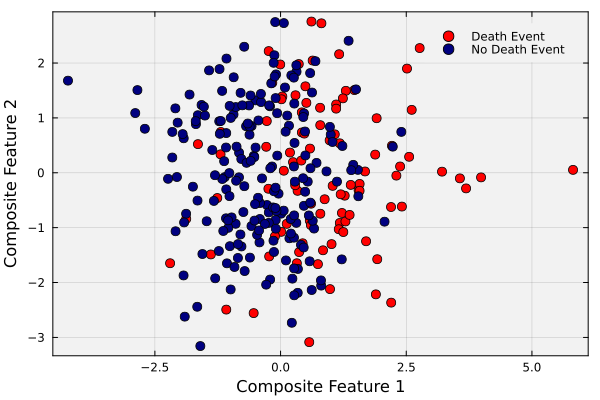

In [21]:
let

    # initialize -
    death_event = dataset[:, :death_event] |> Vector; # extract death_event labels
    

    # create scatter plot
    scatter([Y[death_event .== 1, 1]], [Y[death_event .== 1, 2]]; color=:red, label="Death Event", markersize=5)
    scatter!([Y[death_event .== -1, 1]], [Y[death_event .== -1, 2]]; color=:navy, label="No Death Event", markersize=5)

    # background, and labels
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Composite Feature 1", fontsize=18)
    ylabel!("Composite Feature 2", fontsize=18)
end

__What do you observe?__ Do the principal components help to separate the classes based on the `death_event` label? 

Based on the first two principal components (which capture the variance shown above), we can see that there is partial separation between the classes, but substantial overlap remains. The red points (death events) and navy points (survival) occupy overlapping regions of the principal component space, indicating that the directions of maximum variance in the clinical features do not fully align with the binary outcome.

> While PCA has reduced the dimensionality and captured the dominant variance patterns, the features with the highest variance may not be the most discriminative for predicting patient outcomes. Linear combinations of features that maximize variance (principal components) differ from linear combinations that maximize class separation.

To achieve better class separation, supervised dimensionality reduction methods like Linear Discriminant Analysis (LDA) would be more appropriate, as they explicitly optimize for between-class variance while minimizing within-class variance, making them better suited for classification tasks where class labels are known.

___

## Summary
This activity applied eigendecomposition of the empirical covariance matrix to perform Principal Component Analysis on a heart disease dataset, projecting 13-dimensional patient data into a 2-dimensional subspace.

> __Key Takeaways:__
> 
> * **Covariance matrix eigendecomposition reveals variance structure:** The eigenvectors of the empirical covariance matrix represent directions of maximum variance in the data, with corresponding eigenvalues quantifying variance magnitude along each direction.
> * **QR iteration computes eigendecomposition through iterative factorization:** The QR algorithm transforms matrices toward diagonal form by repeatedly decomposing into orthogonal and upper-triangular factors, converging to eigenvalues on the diagonal.
> * **PCA projects data onto principal component subspaces:** Projecting centered data onto the top eigenvectors reduces dimensionality while preserving maximum variance, revealing structure that may correspond to class separation.


PCA provides a principled approach to dimensionality reduction for visualization and feature engineering.

___